# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the terminal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="assets/pic1.png"/>

Then you will want to run the above command:

<img src="assets/pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## Project Definition

## Additional Background

Marketing new products and offers is a difficult and critical aspect to any
business endeavor. Well established companies such as Starbucks regularly
require new marketing strategies in order to maintain their customer loyalty
and maintain an advantage ahead of their competition.

Targeting customers with new offers and promotions can have mixed results
depending on the customer's preferences and interests. While some promotions
may encourage increased attendance, other promotions to the same customer base
may not elicit strong responses, or perhaps elicit negative responses.
Building advertising models that are careful to consider customer pervious
habits and demographic information can produce tailored recommendations to
deliver the most effective promotion strategy in an effort to maximize
customer loyalty.

The business case for building effective marketing models are clear, additional
technological implications about time-phased recommendations presents an 
interesting challenge to build effective models where a recommendation may 
differ depending on timing in addition to a customer's profile.

## Problem Statement

The analysis for this final report has developed predictive models that can
predict if a BOGO offer will be effective provided BOGO offer details as well
as customer profile data.

## Metrics

The models generated will be evaluated using accuracy and against a 
DummyClassifier that will serve as a baseline accuracy. The DummyClassifier 
will select the most frequent class regardless of inputs. This will provide 
insight to any applied bias to the datasets.

## Analysis

### Data Exploration

In [1]:
!python -m pip install black isort scikit-learn

In [2]:
import sys
sys.version

'3.9.0 | packaged by conda-forge | (default, Nov 26 2020, 07:53:15) [MSC v.1916 64 bit (AMD64)]'

In [3]:
%load_ext autoreload

import pathlib
import pandas as pd
import numpy as np

from IPython.display import display

%matplotlib inline

# read in the json files
data_dir = pathlib.Path('data')
files = {stem: data_dir / f"{stem}.json" 
         for stem in ('portfolio','profile', 'transcript')}
dataframes = {key: pd.read_json(file, orient='records', lines=True)
              for key, file in files.items()}
portfolio = dataframes.get("portfolio")
profile = dataframes.get("profile")
transcript = dataframes.get("transcript")

In [4]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [5]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [6]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


## Data Preprocessing

The following cell will write a file into a local module and be loaded to clean
the dataframes before feature engineering will be performed. This will add
values to null that were coded as another value, expand nested data types into
columns; such as lists; categorize columns where appropriate, and convert
date columns into DateTime values.

In [7]:
%autoreload 2
from capstone_tools.data_cleaners import clean

In [8]:
clean_dataframes = {key: clean(df, key) for key, df in dataframes.items()}
portfolio = clean_dataframes['portfolio']
profile = clean_dataframes['profile']
transcript = clean_dataframes['transcript']

In [9]:
print('Portfolio:')
display(portfolio.head())
print('Profile:')
display(profile.head())
print('Transcript:')
display(transcript.head())

Portfolio:


,offer_reward,offer_difficulty,offer_type,id,web,email,mobile,social,offer_duration
0,10,10,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,168.0
1,10,10,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,120.0
2,0,0,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0,96.0
3,5,5,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,168.0
4,5,20,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,240.0


Profile:


,gender,age,id,became_member_on,income
0,NaN,NaN,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,NaN,NaN,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,NaN,NaN,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN


Transcript:


,person,event,time,offer_id,reward,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


## Merge Data to Events

In [10]:
def merge_data(df_map):
    transcript = df_map['transcript']
    profile = df_map['profile']
    portfolio = df_map['portfolio']
    return (
        transcript
        .merge(profile, left_on='person', right_on='id', how='left')
        .drop(['id'], axis=1)
        .merge(portfolio, left_on='offer_id', right_on='id', how='left')
        .drop(['id'], axis=1)
    )

events = merge_data(clean_dataframes)
events.head()

,person,event,time,offer_id,reward,amount,gender,age,became_member_on,income,offer_reward,offer_difficulty,offer_type,web,email,mobile,social,offer_duration
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,F,75.0,2017-05-09,100000.0,5.0,5.0,bogo,1.0,1.0,1.0,0.0,168.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,NaN,2017-08-04,NaN,5.0,20.0,discount,1.0,1.0,0.0,0.0,240.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,M,68.0,2018-04-26,70000.0,2.0,10.0,discount,1.0,1.0,1.0,0.0,168.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN,NaN,2017-09-25,NaN,2.0,10.0,discount,1.0,1.0,1.0,1.0,240.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN,NaN,2017-10-02,NaN,10.0,10.0,bogo,1.0,1.0,1.0,1.0,120.0


## Data Visualization

In [11]:
%autoreload 2
from capstone_tools.enums import Event

Comparing Advertising types - there appears to be even distribution of web, email, mobile, and social types and more BOGO and discount types over informational

### Portfolio Data

Comparing offers to difficulty and reward intensities, there is not an even
distribution, but does not appear to be skewed, the log data will need to be compared to evaluate if this is true.

(<Figure size 1296x432 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Offer Types by Category'}, xlabel='Advertising Type', ylabel='Count'>,
        <AxesSubplot:title={'center':'Reward and Difficulty Offer Distribution'}, xlabel='Relative Intensity', ylabel='Count'>],
       dtype=object))

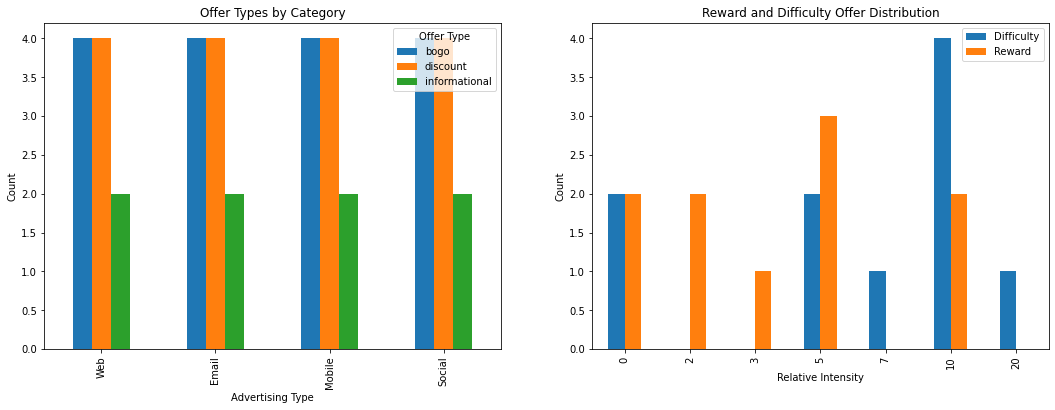

In [12]:
import matplotlib.pyplot as plt

def plot_offers_metrics_basic(portfolio: pd.DataFrame):
    fig, axs = plt.subplots(1, 2, figsize=(18,6))
    (
        portfolio
        .rename(columns=lambda x: x.title().replace('_', ' '))
        .groupby('Offer Type')
        .count()
        [['Web', 'Email','Mobile', 'Social']]
        .T
        .plot(
            kind='bar',
            xlabel='Advertising Type',
            ylabel='Count',
            ax=axs[0],
            title='Offer Types by Category',
        )
    )
    (
        pd.concat(objs=(
            portfolio.groupby('offer_difficulty').count()[['offer_reward']].rename(columns=lambda _: 'Difficulty'),
            portfolio.groupby('offer_reward').count()[['offer_difficulty']].rename(columns=lambda _: 'Reward')
        ), axis=1).plot(
            kind='bar',
            ax=axs[1],
            xlabel='Relative Intensity',
            ylabel='Count',
            title='Reward and Difficulty Offer Distribution')
    )
    return fig, axs

plot_offers_metrics_basic(portfolio)

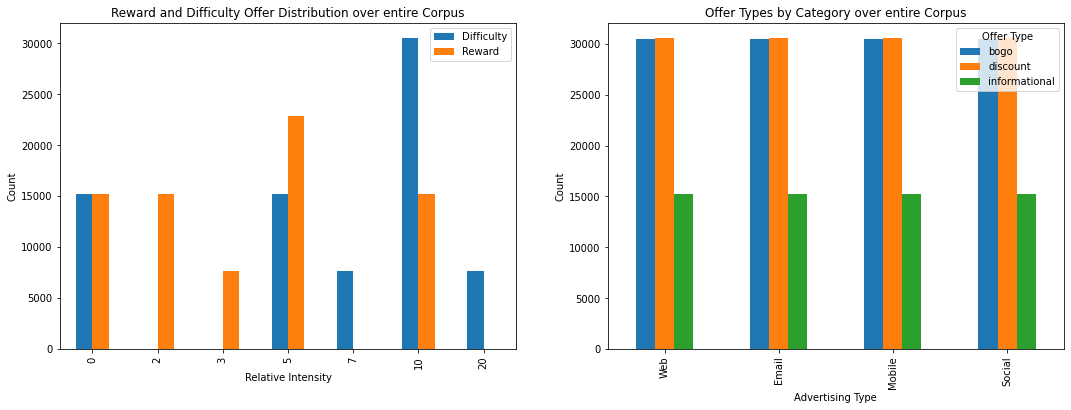

In [13]:
def plot_offers_metrics(transcript: pd.DataFrame, portfolio: pd.DataFrame):
    offers_sent = (
        pd.merge(
            transcript,
            portfolio,
            left_on='offer_id',
            right_on='id'
        )
        .query(f'event == "{Event.received}"')
    )

    fig, axs = plt.subplots(1, 2, figsize=(18,6))

    (
        pd.concat(objs=(
            offers_sent.groupby('offer_difficulty').count()[['offer_reward']].rename(columns=lambda _: 'Difficulty'),
            offers_sent.groupby('offer_reward').count()[['offer_difficulty']].rename(columns=lambda _: 'Reward')
        ), axis=1).plot(
            kind='bar',
            ax=axs[0],
            xlabel='Relative Intensity',
            ylabel='Count',
            title='Reward and Difficulty Offer Distribution over entire Corpus')
    )

    (
        offers_sent
        .rename(columns=lambda x: x.title().replace('_', ' '))
        .groupby('Offer Type')
        .count()
        [['Web', 'Email','Mobile', 'Social']]
        .T
        .plot(
            kind='bar',
            xlabel='Advertising Type',
            ylabel='Count',
            ax=axs[1],
            title='Offer Types by Category over entire Corpus',
        )
    );
    return fig, axs

plot_offers_metrics(transcript, portfolio);

Reviewing the entire corpus, the distribution appears to be the same.

### Profile Data

The profile data is a bit more tricky, nans exist within this dataset and some information will have to be provided as an additional category. Looking at Gender and age distributions there is a significant portion of nan values. As well as a significant skew in gender category:

In [14]:
print(f"Number of Profiles: {len(profile)}")
print(f"Number of Complete Profiles: {len(profile.dropna())}")


Number of Profiles: 17000
Number of Complete Profiles: 14825


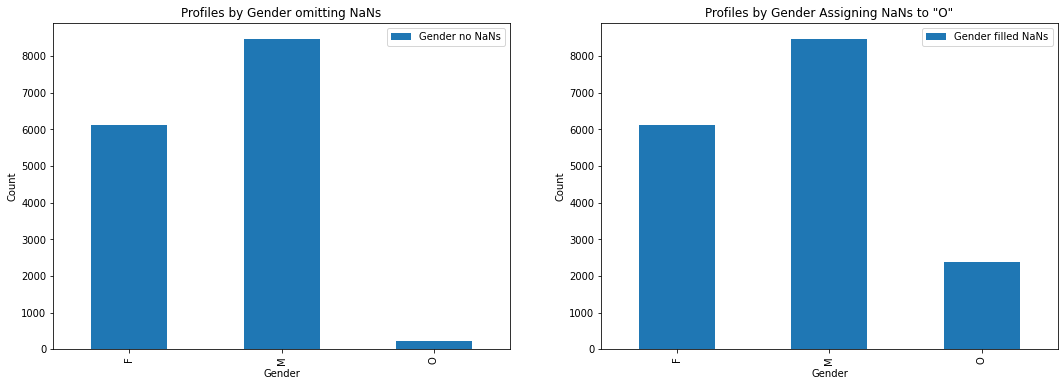

In [15]:
def plot_gender(profile: pd.DataFrame):
    fig, axs = plt.subplots(1, 2, figsize=(18,6))

    (
        profile
        # .assign(gender=lambda df: df['gender'].fillna('O'))
        .groupby('gender')
        .count()
        [['id']]
        .rename(columns=lambda _: 'Gender no NaNs')
        .plot(
            kind='bar',
            xlabel='Gender',
            ylabel='Count',
            ax=axs[0],
            title='Profiles by Gender omitting NaNs',
        )
    );
    (
        profile
        .assign(gender=lambda df: df['gender'].fillna('O'))
        .groupby('gender')
        .count()
        [['id']]
        .rename(columns=lambda _: 'Gender filled NaNs')
        .plot(
            kind='bar',
            xlabel='Gender',
            ylabel='Count',
            ax=axs[1],
            title='Profiles by Gender Assigning NaNs to "O"',
        )
    )
    return fig, axs

plot_gender(profile);

There is significant skew in gender where Male is the most common followed by
female and other is a significant minor population - much lower than the profiles omitting gender all together.

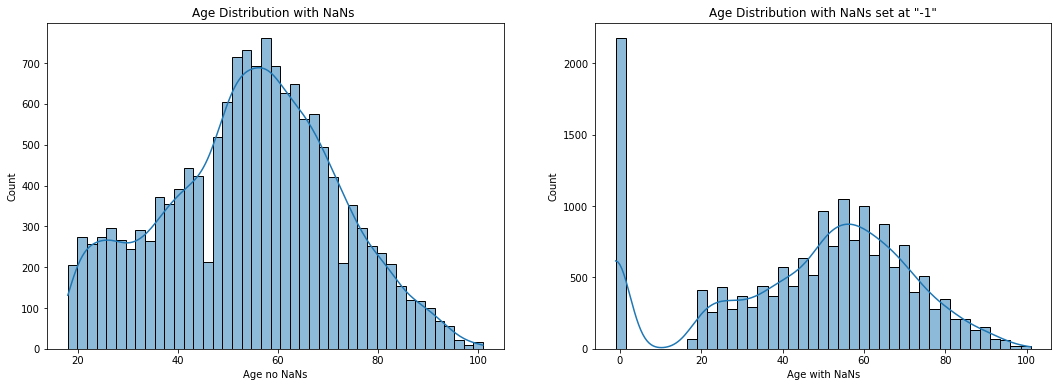

In [16]:
import seaborn as sns


def plot_age(profile):
    fig, axs = plt.subplots(1, 2, figsize=(18,6))
    age_profile_no_nans = (
        profile
        # .assign(gender=lambda df: df['age'].fillna(99))
        # .groupby('age')
        # .count()
        [['age']]
        .rename(columns=lambda _: 'Age no NaNs')
        .dropna()
    )
    age_profile_with_nan = (
        profile
        .assign(age=lambda df: df['age'].fillna(-1))
        # .groupby('age')
        # .count()
        [['age']]
        .rename(columns=lambda _: 'Age with NaNs')
    )
    splots = []
    splots.append(sns.histplot(
        data=age_profile_no_nans,
        x = 'Age no NaNs',
        kde=True,
        ax=axs[0]
    ))
    splots.append(sns.histplot(
        data=age_profile_with_nan,
        x = 'Age with NaNs',
        kde=True,
        ax=axs[1],
    ))
    splots[0].set_title('Age Distribution with NaNs ')
    splots[1].set_title('Age Distribution with NaNs set at "-1"')
    return splots

plot_age(profile);

Moreover - there appears to be use skewness with income and membership
length for income, age, and gender:

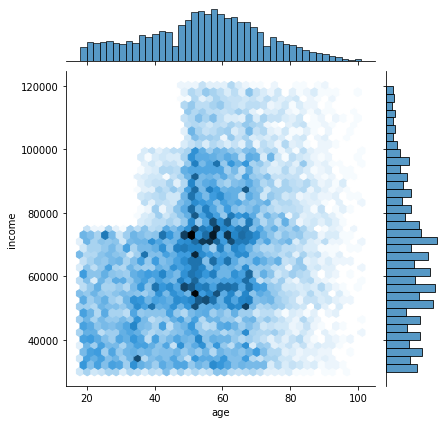

In [17]:
sns.jointplot(data=profile, x='age', y='income', kind='hex')

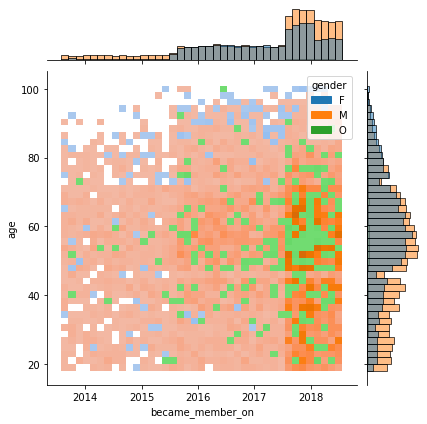

In [18]:
sns.jointplot(
    data=profile,
    x='became_member_on',
    y='age',
    kind='hist',
    hue='gender'
)

There appears to be significantly more newer members that select the non-binary gender and there appears to be much more members added between 2015 and 2016

## Feature Generation

Feature generation will transform the cleaned data to derived values.
The following list describes each field and the intended use:

1. `event_id`: This is a unique id generated for each unique offer period 
   started by an "Offer Received" event
2. `sales`: This is the amount of sales generated for each `event_id`
3. `cost`: This is the cost incurred by the `event_id` (i.e. if a discount was 
   applied to a sale - the amount of the discount was captured here - a.k.a the reward of the offer)
4. `profit`: This is sales - cost for each `event_id`
5. `offer_viewed`: This is marked true for each item after the "Offer Viewed"
   event
6. `offer_valid`: This is marked true for each event less than the offer 
   duration (defined by `elapsed_time` column)
7. `offer_redeemed`: This is marked true only at events labeled as "Offer   
   Completed" - intended to be used to generate `offer_success` column
8. `offer_success`: This is marked true if and only if `offer_viewed`, 
   `offer_valid`, and `offer_redeemed` are all true
9.  `gender`: This column has been assigned a numerical category where -1 is 
    nan, 0 is male, 1 is female, 2 is other
10. `became_member_on`: This column has been converted to a numerical category
    where each enumeration represents an equal distribution cut of 5 separate
    categories where 1 are the most loyal customers and 5 are the newest 
    customers. 0 is NaN
11. `age`: This column has been converted to a numerical category
    where each enumeration represents an equal distribution cut of 5 separate
    categories where 1 are the youngest customers and 5 are the oldest 
    customers. 0 is NaN
12. `income`: This column has been converted to a numerical category
    where each enumeration represents an equal distribution cut of 5 separate
    categories where 1 are the lowest income customers and 5 are the most affluent customers. 0 is NaN
13. `offer_start`: this column is filled with the value of when the offer was 
    started for all offers within the `event_id`
14. `elapsed_time`: this column is the time elapsed after the start of the 
    event_id defined by `offer_start`


`profit` was originally used as my target value to generate a `best_offer` 
category, but was ultimately scrapped. `offer_success` is ultimately used to
evaluate given portfolio and profile information if an offer will be successful
to the individual.

In [19]:
%autoreload 2
from capstone_tools.feature_generation import transform

In [42]:
from capstone_tools.enums import Offer
from capstone_tools.feature_generation import transform
tx_events = transform(events, 'events')
outcomes = {}
for offer in Offer.to_list():
    outcomes[offer] = transform(tx_events, 'outcomes', offer=offer)
outcomes['All'] = transform(tx_events, 'outcomes', offer=None)


In [43]:
print("Event Data - Transformed:")
display(tx_events.head())
print("Outcome Data - Transformed:")
display(outcomes[Offer.discount].head())

Event Data - Transformed:


,person,event,time,offer_id,reward,amount,gender,age,became_member_on,income,...,event_id,offer_start,elapsed_time,offer_valid,offer_viewed,offer_redeemed,offer_success,sales,costs,profit
index,,,,,,,,,,,,,,,,,,,,,
155351,129d54616fba45cda310d24179b0643d,offer received,408,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,1,4,4,1,...,000220b2730c49459da9fe32129dc3f6,408.0,0.0,1,0,0,0,0.00,0.0,0.00
168993,129d54616fba45cda310d24179b0643d,transaction,414,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,1.13,1,4,4,1,...,000220b2730c49459da9fe32129dc3f6,408.0,6.0,1,0,0,0,1.13,0.0,1.13
172394,129d54616fba45cda310d24179b0643d,offer viewed,420,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,1,4,4,1,...,000220b2730c49459da9fe32129dc3f6,408.0,12.0,1,1,0,0,1.13,0.0,1.13
6399,5db2207d5a194b81b986f37107ef63f7,offer received,0,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,-1,NaN,3,NaN,...,000229b97f63420e8799a38773c7a18f,0.0,0.0,1,0,0,0,0.00,0.0,0.00
14124,5db2207d5a194b81b986f37107ef63f7,offer viewed,0,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,-1,NaN,3,NaN,...,000229b97f63420e8799a38773c7a18f,0.0,0.0,1,1,0,0,0.00,0.0,0.00


Outcome Data - Transformed:


,event_id,time,offer_viewed,offer_redeemed,offer_success,sales,costs,profit,person,offer_id,offer_reward,offer_difficulty,gender,age,became_member_on,income,offer_type
0,0007813652d94bda8509e4956b9335d6,540,1,1,1,27.87,3.0,24.87,df3da7cfcf614b3481b65c89657994ed,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0,7.0,0,2,0,4,discount
1,00082957ac6b4cc59439b6b27bc0bb3e,210,1,1,1,7.86,3.0,4.86,70743262fadd4895adf8e5907da3c654,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0,7.0,1,0,1,0,discount
2,000a0ba2f60749bebfcf8e91d56b6d7a,282,1,1,1,14.71,3.0,11.71,793913a9f33c4ae596cfa55ef3bfd901,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0,7.0,0,4,3,3,discount
3,000be0436698410fb00af359d00a63f0,336,1,0,0,0.00,0.0,0.00,b64fdf87a8424569ab616686c1c48641,fafdcd668e3743c1bb461111dcafc2a4,2.0,10.0,-1,NaN,3,NaN,discount
4,000e70c0183c4ab48d9a80656fadb3f1,504,0,0,0,0.00,0.0,0.00,42fd8e1e7c4548c9b4c151a1c3af134b,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,20.0,1,2,3,0,discount


## Data Refinement

Evaluation by Offer=bogo


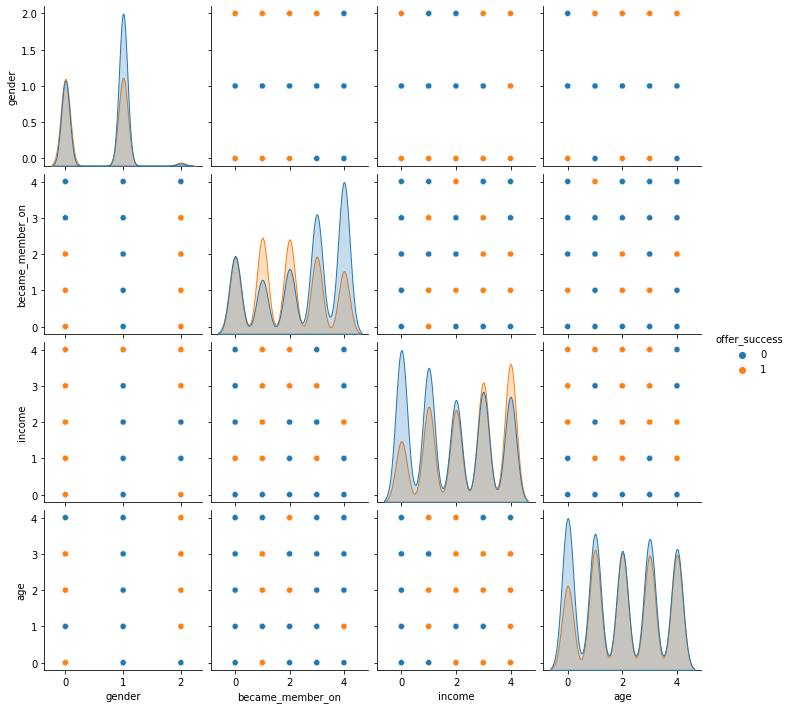

Evaluation by Offer=discount


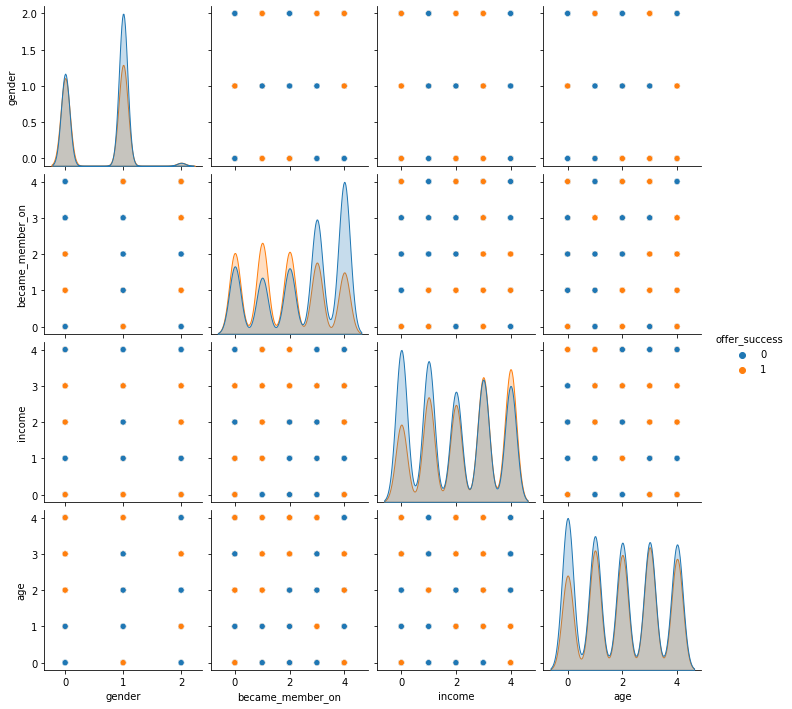

Evaluation by Offer=info


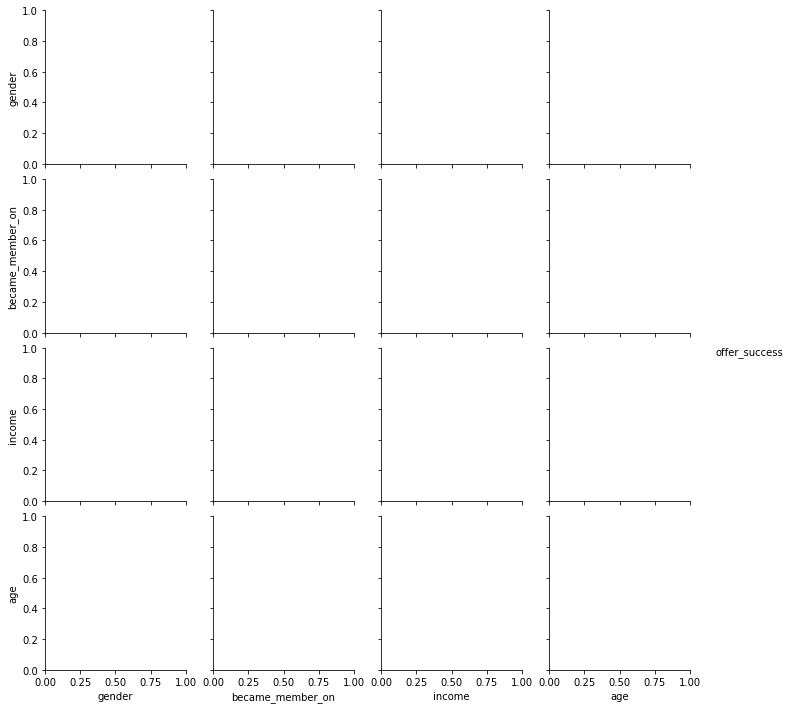

Evaluation by Offer=All


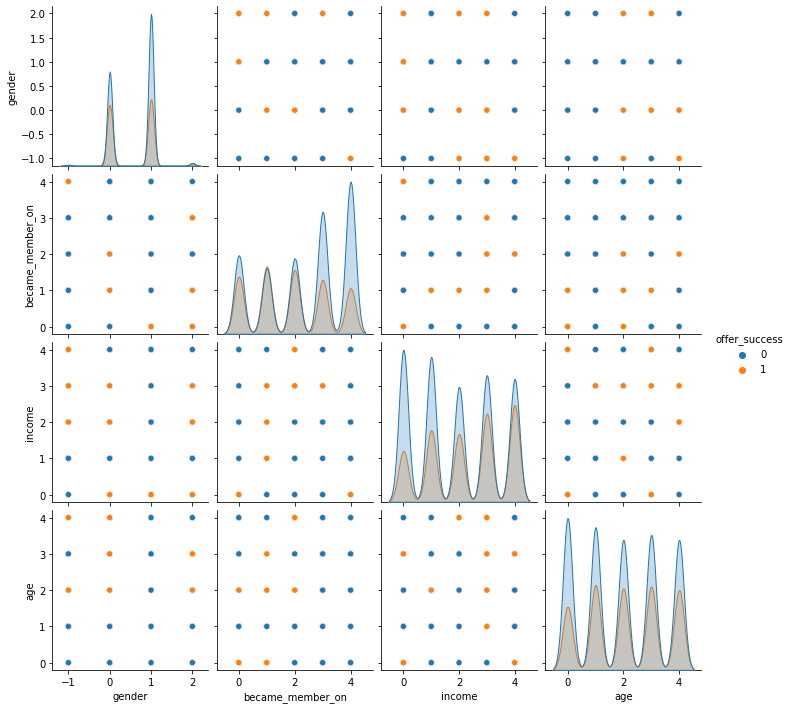

In [44]:
drop_cols = ['person', 'offer_id', 'event_id', 'offer_type', 'offer_viewed', 'offer_redeemed', 'costs', 'profit']
keep_cols = ['gender', 'became_member_on', 'income', 'age', 'offer_success']

# sns.pairplot(outcomes.drop(drop_cols, axis=1), hue='offer_success')
for key, outcome_df in outcomes.items():
    print(f"Evaluation by Offer={key}")
    sns.pairplot(
        outcome_df[keep_cols].dropna().astype(int), 
        hue='offer_success', 
    )
    plt.show()

Engineering Decision: It appears that BOGO offers provide the most variation 
between offer success and failure. I will select this subset of data to
evaluate my models against.  

Engineering Decision: I have also made the decision to include NAN categories
as '0' categories for `['gender', 'became_member_on', 'income', 'age']`. This
decision was made since I already have converted numerical values into
categories the inclusion of NANs are much easier to keep.

In [46]:
from capstone_tools.feature_generation import EventTransformer

def one_hot_cat_cols(df, cols):
    for col in cols:
        df = EventTransformer.merge_cats_to_one_hots(df, col)
    return df

cat_cols = ['became_member_on', 'gender', 'age', 'income']
model_data = one_hot_cat_cols(outcomes[Offer.bogo], cat_cols)

In [48]:
print("Model Data - BOGO offers with one-hot values for category cols:")
display(model_data)


Model Data - BOGO offers with one-hot values for category cols:


,event_id,time,offer_viewed,offer_redeemed,offer_success,sales,costs,profit,person,offer_id,...,age_0,age_1,age_2,age_3,age_4,income_0,income_1,income_2,income_3,income_4
0,000220b2730c49459da9fe32129dc3f6,420,1,0,0,1.13,0.0,1.13,129d54616fba45cda310d24179b0643d,4d5c57ea9a6940dd891ad53e9dbe8da0,...,0,0,0,0,1,0,1,0,0,0
1,0002b54031f44094b18a426774737129,360,1,1,1,11.81,5.0,6.81,1f9b6e1cebeb48dcb6cd5965b408c989,f19421c1d4aa40978ebb69ca19b0e20d,...,1,0,0,0,0,1,0,0,0,0
2,0003098c6ab6419bb8a44103da55f9cf,504,0,0,0,0.00,0.0,0.00,0df14ab3f3274a0bbc4c76acef224f02,9b98b8c7a33c4b65b9aebfe6a799e6d9,...,1,0,0,0,0,0,1,0,0,0
3,00050b1e361648e4a80390bad36135f3,600,0,1,0,21.79,10.0,11.79,be85e0f528c24ae9acae162d6a2bc832,4d5c57ea9a6940dd891ad53e9dbe8da0,...,1,0,0,0,0,0,0,0,1,0
4,000b1b3be86d407a8ea15ba3f5496910,522,1,1,1,24.39,5.0,19.39,4f519b617c554988b17714a0a4ac767e,9b98b8c7a33c4b65b9aebfe6a799e6d9,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31458,fff76f197ede4da8a8b58cc4392b3cb3,246,1,1,1,26.66,5.0,21.66,be63245084964ff0a3e154202123e222,9b98b8c7a33c4b65b9aebfe6a799e6d9,...,0,0,1,0,0,0,0,0,1,0
31459,fff8445bf2fb470d890ca3202e821244,462,1,1,1,85.61,10.0,75.61,aeea18cf2e8d455c98453c546292a9f6,4d5c57ea9a6940dd891ad53e9dbe8da0,...,0,0,0,1,0,0,0,0,1,0
31460,fff8da4cd1274bc59db580b38332ef49,414,0,1,0,15.59,5.0,10.59,304183fd053441f0a13bc4d648b7cff1,9b98b8c7a33c4b65b9aebfe6a799e6d9,...,0,0,0,0,1,1,0,0,0,0
31461,fffcac3900e64e51aba3c02ff6f1d6d6,606,1,0,0,2.76,0.0,2.76,7b864e6e295f4b4b8da46f9f43ef673e,4d5c57ea9a6940dd891ad53e9dbe8da0,...,1,0,0,0,0,1,0,0,0,0


## Model Implementation

### Standard Scaling

If nans still exist within the data the models will break, in order to prevent
an accident - I will apply a median imputer to impute any nan data - though my
data cleaning should have accounted for this already.

In [49]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

In [51]:

def get_labels(model_data, label_cols):
    """Get label columns from model_data"""
    return model_data[label_cols]

def get_data(model_data, drop_cols):
    """Get data columns from model_data"""
    return model_data.drop(drop_cols, axis=1)

def make_pipeline(pca=None):
    """
    Make a data processing pipeline appends a trained PCA model if provided
    """
    pre_proc = Pipeline([ 
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
        ])
    if pca:
        return Pipeline([ 
            ("preprocessor", pre_proc),
            ('pca', pca),
        ])
    return pre_proc

In [58]:
label_cols  = [
    "event_id",
    "person",
    "offer_id",
    # "viewed_and_redeemed",
    "offer_success"
]
drop_cols = [
    "offer_viewed",
    "offer_redeemed",
    "sales",
    "costs",
    "profit",
    "time",
    "offer_type",
]
drop_cols.extend(label_cols)
labels = get_labels(model_data, label_cols)
data = get_data(model_data, drop_cols)
print("Data Input:")
display(data.head())
print("Data Labels:")
display(labels.head())

Data Input:


,offer_reward,offer_difficulty,became_member_on_0,became_member_on_1,became_member_on_2,became_member_on_3,became_member_on_4,gender_-1,gender_0,gender_1,...,age_0,age_1,age_2,age_3,age_4,income_0,income_1,income_2,income_3,income_4
0,10.0,10.0,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,1,0,0,0
1,5.0,5.0,0,0,0,1,0,0,1,0,...,1,0,0,0,0,1,0,0,0,0
2,5.0,5.0,0,0,0,1,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
3,10.0,10.0,0,1,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0
4,5.0,5.0,0,0,0,0,1,0,0,1,...,0,0,1,0,0,0,0,0,0,1


Data Labels:


,event_id,person,offer_id,offer_success
0,000220b2730c49459da9fe32129dc3f6,129d54616fba45cda310d24179b0643d,4d5c57ea9a6940dd891ad53e9dbe8da0,0
1,0002b54031f44094b18a426774737129,1f9b6e1cebeb48dcb6cd5965b408c989,f19421c1d4aa40978ebb69ca19b0e20d,1
2,0003098c6ab6419bb8a44103da55f9cf,0df14ab3f3274a0bbc4c76acef224f02,9b98b8c7a33c4b65b9aebfe6a799e6d9,0
3,00050b1e361648e4a80390bad36135f3,be85e0f528c24ae9acae162d6a2bc832,4d5c57ea9a6940dd891ad53e9dbe8da0,0
4,000b1b3be86d407a8ea15ba3f5496910,4f519b617c554988b17714a0a4ac767e,9b98b8c7a33c4b65b9aebfe6a799e6d9,1


In [76]:
def scale_data(data, preprocessor):
    data_scaled = preprocessor.fit_transform(data)
    _, n_cols = data_scaled.shape
    if n_cols == len(data.columns):
        return pd.DataFrame(
            data=data_scaled, columns=data.columns, index=data.index
        )
    return pd.DataFrame(data=data_scaled, index=data.index)

preprocessor = make_pipeline()
data_scaled = scale_data(data, preprocessor)
display(data_scaled)

,offer_reward,offer_difficulty,became_member_on_0,became_member_on_1,became_member_on_2,became_member_on_3,became_member_on_4,gender_-1,gender_0,gender_1,...,age_0,age_1,age_2,age_3,age_4,income_0,income_1,income_2,income_3,income_4
22696,1.017368,1.017368,2.191157,-0.45443,-0.474576,-0.539853,-0.572681,2.621446,-0.758755,-0.991822,...,-0.455363,-0.477088,-0.452392,-0.465672,-0.448904,-0.447796,-0.468533,-0.428815,-0.468785,-0.485020
9343,-0.982929,-0.982929,-0.456380,-0.45443,2.107144,-0.539853,-0.572681,-0.381469,1.317948,-0.991822,...,-0.455363,-0.477088,2.210472,-0.465672,-0.448904,-0.447796,-0.468533,-0.428815,-0.468785,2.061772
4357,-0.982929,-0.982929,-0.456380,-0.45443,-0.474576,1.852355,-0.572681,-0.381469,1.317948,-0.991822,...,-0.455363,-0.477088,2.210472,-0.465672,-0.448904,-0.447796,-0.468533,2.332009,-0.468785,-0.485020
23657,1.017368,1.017368,-0.456380,2.20056,-0.474576,-0.539853,-0.572681,-0.381469,-0.758755,1.008245,...,-0.455363,-0.477088,-0.452392,2.147434,-0.448904,-0.447796,-0.468533,-0.428815,-0.468785,2.061772
25381,1.017368,1.017368,-0.456380,-0.45443,2.107144,-0.539853,-0.572681,-0.381469,-0.758755,1.008245,...,-0.455363,2.096051,-0.452392,-0.465672,-0.448904,-0.447796,-0.468533,2.332009,-0.468785,-0.485020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15999,1.017368,1.017368,-0.456380,-0.45443,-0.474576,1.852355,-0.572681,-0.381469,1.317948,-0.991822,...,-0.455363,2.096051,-0.452392,-0.465672,-0.448904,-0.447796,2.134321,-0.428815,-0.468785,-0.485020
7626,1.017368,1.017368,-0.456380,-0.45443,2.107144,-0.539853,-0.572681,-0.381469,1.317948,-0.991822,...,-0.455363,-0.477088,-0.452392,-0.465672,2.227647,-0.447796,2.134321,-0.428815,-0.468785,-0.485020
3472,1.017368,1.017368,-0.456380,-0.45443,-0.474576,-0.539853,1.746173,-0.381469,1.317948,-0.991822,...,2.196051,-0.477088,-0.452392,-0.465672,-0.448904,-0.447796,-0.468533,2.332009,-0.468785,-0.485020
21727,-0.982929,-0.982929,-0.456380,-0.45443,-0.474576,1.852355,-0.572681,-0.381469,-0.758755,1.008245,...,2.196051,-0.477088,-0.452392,-0.465672,-0.448904,2.233158,-0.468533,-0.428815,-0.468785,-0.485020


### Train, Test, Validation Sets

In [60]:
import pickle

def write_col_names(location: pathlib.Path, data: pd.DataFrame):
    """Write column names to location"""
    file = location.joinpath('col_names.pkl')
    with open(file, 'wb') as fh:
        pickle.dump(data.columns, fh)

root = pathlib.Path('data/processed')
root.mkdir(exist_ok=True, parents=True)
write_col_names(root, data)

In [61]:
import pathlib
import pickle
import numpy as np

from capstone_tools.data_splitting import PreSplitData, process_scaled_data

val_splits = 0.2
test_splits = 0.2
data_cargo = PreSplitData(data_scaled, labels, test_splits, val_splits)
root = pathlib.Path('.')
location = root / "data/processed"

process_scaled_data(data_cargo, location)


## PCA


*Can start from here if you have saved your data*

In [62]:
import pathlib
import numpy as np
import pandas as pd

from capstone_tools.data_loaders import load_dataset

root = pathlib.Path('data/processed')
train_loc = root.joinpath('train')
train_data, train_labels = load_dataset(train_loc)

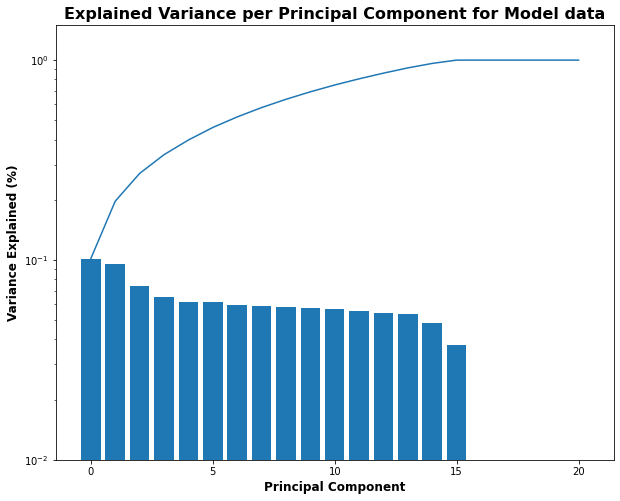

In [69]:
from sklearn.decomposition import PCA

pcas = (PCA() for _ in range(1))

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
dataset = (train_data,)
names = ("Model",)
axs = (ax,)
for ax, pca, data, name in zip(axs, pcas, dataset, names):
    results = pca.fit_transform(data)
    vars = pca.explained_variance_ratio_
    n = len(vars)
    ax.bar(range(n), vars)
    ax.plot(range(n), vars.cumsum())
    ax.set_ylabel("Variance Explained (%)", fontweight='bold', fontsize=12)
    ax.set_xlabel(
        f"Principal Component",
        fontweight='bold',
        fontsize=12,
    )
    ax.semilogy()
    ax.set_ylim([0.01, 1.5])
    ax.set_title(
        f"Explained Variance per Principal Component for {name.title()} data",
        fontweight='bold',
        fontsize=16,
    )

plt.show()

Now that I have increased the number of data columns into categorical data,
PCA appears to create more use, where I can reduce the number of components by
close around 40% if I were to reduce the number of components down to 15 and
still retain 100% of the variance.

### New Pipeline with PCA in line

In [80]:
pipeline_pca = PCA(n_components=15)
pca_preprocessor = make_pipeline(pipeline_pca)
data_scaled = scale_data(data, pca_preprocessor)
print("Scaled data wtih PCA applied:")
display(data_scaled.head())

Scaled data wtih PCA applied:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
22696,0.270234,1.428850,2.586098,-1.314301,-0.797313,0.928886,-0.277778,-0.338374,-1.100685,-0.396680,0.643909,1.234907,0.156145,1.685199,-0.282567
9343,2.549380,-1.644775,-0.857079,-0.432272,0.270677,-0.192223,1.130957,1.259244,-1.977645,1.057316,-0.273992,-1.473155,-0.719024,0.119113,-0.188534
4357,1.038802,-1.562395,-0.448989,1.026756,-1.153379,0.736682,0.435915,-1.075901,-1.284727,-1.802280,-0.638362,-1.649991,-1.891620,-0.699108,0.002182
23657,0.686365,1.392251,-0.916238,-1.619063,-0.486751,-2.635043,-1.067007,-0.722911,0.249004,0.799678,1.576467,0.148040,0.524720,-1.192824,0.015092
25381,-1.003022,1.479274,-0.606811,-1.226894,-0.349356,2.478883,0.999725,-0.495256,-0.084063,1.671452,-0.181624,-0.595570,-0.530871,-2.171459,-0.076368


## Model Predictions - Unsupervised Learning

The following segment investigates if the profiles follow similar behaviors 
and if they can be classified into clusters.

In [81]:
import pathlib

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

from capstone_tools.data_loaders import load_dataset

In [82]:
root = pathlib.Path('data/processed')

train_loc = root.joinpath('train')
train_data, _ = load_dataset(train_loc)
train_data = train_data.values

In [83]:
mean_dist = []
total_clusters = 30
for n in range(1, total_clusters):
    clf = KMeans(n_clusters=n)
    clf.fit(train_data)
    d = np.sqrt(-clf.score(train_data))
    mean_dist.append(d)


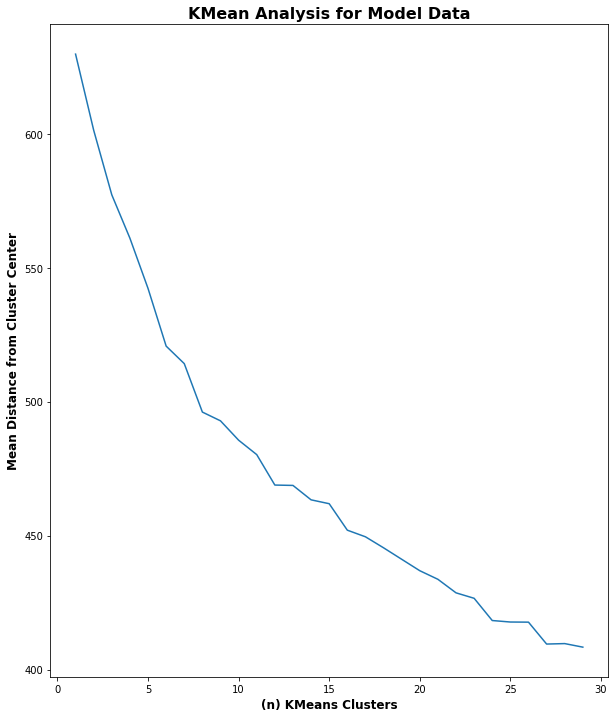

In [85]:
fix, ax = plt.subplots(1, 1, figsize=(10, 12))
ax.plot(range(1, total_clusters), mean_dist)
# ax.semilogy()
ax.set_ylabel(
    "Mean Distance from Cluster Center",
    fontweight='bold',
    fontsize=12
)
ax.set_xlabel(
    "(n) KMeans Clusters",
    fontweight='bold',
    fontsize=12,
)
# ax.semilogy()
# ax.set_ylim([0.05, 1.5])
ax.set_title(
    "KMean Analysis for Model Data",
    fontweight='bold',
    fontsize=16,
)
plt.show()

There seems to be a two sections where KMeans clustering can be utilized. There
seems to be deviations from the mean distance scores at around 8 clusters. Moving forward, if unsupervised learning is applied, election of either 4 or 8
clusters will be used for the final model.

## Recommendation Model

### Baseline Model

In [86]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
%autoreload 2

import pathlib

import pickle
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

from capstone_tools.data_loaders import load_data_corpus
from capstone_tools.model_trainers import SKLearnModelTrainer


data_loc = pathlib.Path("data/processed")
datasets = load_data_corpus(data_loc)

save_loc = pathlib.Path('models')

In [88]:

baseline_clfs = [
    (DummyClassifier, {}),
    (GaussianNB, {}),
    (RandomForestClassifier, {"n_estimators": 100}),
    (GradientBoostingClassifier, {"n_estimators": 100, "learning_rate": 0.1}),
    (AdaBoostClassifier, {"n_estimators": 100, "learning_rate": 0.1}),
    (DecisionTreeClassifier, {}),#"max_depth": 5, "min_samples_split": 5}),
    (LogisticRegression, {"C": 1}),
]
acc_scores = {}
rel_scores = {}
baseline_score = 0.0
for Clf, kwargs in baseline_clfs:
    datasets = load_data_corpus(data_loc)
    clf = Clf(**kwargs)
    clf_name = clf.__class__.__name__
    model_file = save_loc.joinpath(f"{clf_name.lower()}-model.pkl")
    sk_trainer = SKLearnModelTrainer(clf)
    scores = sk_trainer.train(datasets, save_path=model_file)
    if isinstance(clf, DummyClassifier):
        baseline_score = scores.get('test', 0.0)
    acc_scores[clf_name] = scores
    rel_scores[clf_name] = scores.get('test') - baseline_score
    acc_file = save_loc.joinpath(f"{clf_name.lower()}-scores.pkl")
    with open(acc_file, 'wb') as fh:
        pickle.dump(acc_scores, fh)
    print(
        f"{clf!r}: trained with training accuracy: "
        f"{scores['train']*100:.2f}%"
        f"  test accuracy: {scores['test']*100:.2f}%"
        f"  rel-score: {rel_scores[clf_name]*100:.2f}%"
    )



    

DummyClassifier(): trained with training accuracy: 59.23%  test accuracy: 60.35%  rel-score: 0.00%
GaussianNB(): trained with training accuracy: 65.90%  test accuracy: 66.18%  rel-score: 5.83%
RandomForestClassifier(): trained with training accuracy: 69.90%  test accuracy: 67.84%  rel-score: 7.48%
GradientBoostingClassifier(): trained with training accuracy: 68.58%  test accuracy: 68.62%  rel-score: 8.26%
AdaBoostClassifier(learning_rate=0.1, n_estimators=100): trained with training accuracy: 67.89%  test accuracy: 68.19%  rel-score: 7.83%
DecisionTreeClassifier(): trained with training accuracy: 69.90%  test accuracy: 67.74%  rel-score: 7.39%
LogisticRegression(C=1): trained with training accuracy: 67.97%  test accuracy: 68.50%  rel-score: 8.15%


### Optimization for best model

In [123]:
max_depth = [int(x) for x in 10**(np.linspace(6, 20, 10) / 10)]
max_depth

[3, 5, 8, 11, 16, 23, 34, 48, 69, 100]

In [126]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
best_clf = GradientBoostingClassifier()
learning_rates = [np.round(x, 3) for x in 10**(np.linspace(-30, 0, 10) / 10)]
estimators = [int(x) for x in 10**(np.linspace(0, 26, 10) / 10)]
sample_split = [int(x) for x in 10**(np.linspace(4, 20, 10) / 10)]
max_depth = [int(x) for x in 10**(np.linspace(6, 20, 10) / 10)]

search_grid = {
    "learning_rate": learning_rates,
    "n_estimators": estimators,
    "criterion": ["friedman_mse", "squared_error"],
    "min_samples_split": sample_split,
    "max_depth": max_depth,
}
search_clf = RandomizedSearchCV(
    estimator=best_clf,
    param_distributions=search_grid,
    n_jobs=-1,
)


In [131]:

datasets = load_data_corpus(data_loc)
clf_name = search_clf.__class__.__name__
model_file = save_loc.joinpath(f"{clf_name.lower()}-model.pkl")
sk_trainer = SKLearnModelTrainer(search_clf)
scores = sk_trainer.train(datasets, save_path=model_file)
acc_scores[clf_name] = scores
rel_scores[clf_name] = scores.get('test') - baseline_score
acc_file = save_loc.joinpath(f"{clf_name.lower()}-scores.pkl")
with open(acc_file, 'wb') as fh:
    pickle.dump(acc_scores, fh)



'RandomizedSearchCV'

In [133]:
print(
    f"{search_clf!r}: trained with training accuracy: "
    f"{scores['train']*100:.2f}%"
    f"  test accuracy: {scores['test']*100:.2f}%"
    f"  rel-score: {rel_scores[clf_name]*100:.2f}%"
)


RandomizedSearchCV(estimator=GradientBoostingClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['friedman_mse',
                                                      'squared_error'],
                                        'learning_rate': [0.001, 0.002, 0.005,
                                                          0.01, 0.022, 0.046,
                                                          0.1, 0.215, 0.464,
                                                          1.0],
                                        'max_depth': [3, 5, 8, 11, 16, 23, 34,
                                                      48, 69, 100],
                                        'min_samples_split': [2, 3, 5, 8, 12,
                                                              19, 29, 44, 66,
                                                              100],
                                        'n_estimators': [1, 1, 3, 7, 14, 27, 54,
                                      

In [135]:
search_clf.best_params_

{'n_estimators': 54,
 'min_samples_split': 44,
 'max_depth': 5,
 'learning_rate': 0.046,
 'criterion': 'friedman_mse'}

In [136]:
best_clf = search_clf.best_estimator_

The randomized search provided a similar performing Gradient Boosing Classifier
only producing an increase in test accuracy of 8.22% over a random choice.

### Advanced Model

In [89]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
%autoreload 2
import pathlib

import pickle
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

from capstone_tools.model import RecommendationModel, ModelDimensions
from capstone_tools.model_trainers import TorchTrainer, TorchModelData
from capstone_tools.data_loaders import load_data_corpus


data_loc = pathlib.Path("data/processed")
datasets = load_data_corpus(data_loc)

In [91]:
_, input_dim = datasets['train'].X.shape
output_dim = len(set(datasets['train'].y))

In [92]:
dims = ModelDimensions(
    input_size=input_dim,
    hidden_layers=(256, 256, 256), 
    output_size=output_dim
)
clf = RecommendationModel(
    dims,
    has_dropout=True,
    p_drop=0.2,
    has_batch_norm=True,
)

In [93]:
clf


RecommendationModel(
  (linear_stack): Sequential(
    (0): Linear(in_features=21, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): ReLU()
    (10): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [94]:
optimizer = Adam(clf.parameters(), lr=0.01)
critereon = CrossEntropyLoss()
model_data = TorchModelData(
    model=clf, optimizer=optimizer, critereon=critereon
)
trainer = TorchTrainer(model_data)
model_loc = pathlib.Path('models/nn-rec-model.pth')
losses_loc = pathlib.Path('models/nn-rec-losses.pkl')
model_loc.parent.mkdir(parents=True, exist_ok=True)

In [95]:
epochs = 100
losses = trainer.train(
    datasets,
    n_epochs=epochs,
    batch_size=64,
    save_path=model_loc,
    patience=10,
)
with open(losses_loc, 'wb') as fh:
    pickle.dump(losses, fh)

Epoch: 1	Training Loss:0.6194	Valid Loss:0.5959
Validation Loss decreased(inf -> 0.5959) Saving Model...
Epoch: 3	Training Loss:0.5902	Valid Loss:0.5856
Validation Loss decreased(0.5959 -> 0.5856) Saving Model...
Epoch: 8	Training Loss:0.5845	Valid Loss:0.5835
Validation Loss decreased(0.5856 -> 0.5835) Saving Model...
Early stopping triggered, stopping...Loss:0.5872


In [96]:
print(f"Baseline Score: {baseline_score}")
trainer.eval(datasets['test'], batch_size=64)

Baseline Score: 0.6035277292229462
Test Loss: 0.5843	Accuracy: 68.76 (4327/6293)


<AxesSubplot:title={'center':'Loss over Epoch of FC Neural Network'}, xlabel='Epoch', ylabel='Loss'>

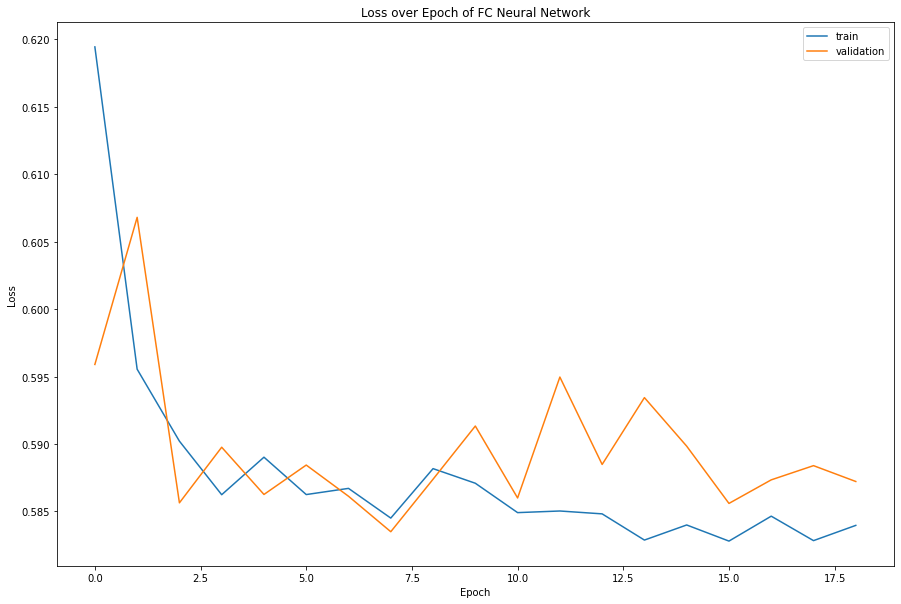

In [97]:
import pandas as pd

pd.DataFrame(losses).plot(
    figsize=(15, 10), xlabel='Epoch', ylabel='Loss', 
    title='Loss over Epoch of FC Neural Network'
)


In [140]:
print(f'FC NN performance above baseline: {68.76-60.35:.2f}%')

FC NN performance above baseline: 8.41%


Though the neural network does perform better than the ML models tested above,
the performance is only 8.4% better than a random choice.

## Final Model Evaluation

Analyzing the Starbucks customer data is quite challenging. The provided data
can be analyzed and manipulated several ways to produce varying degrees of
success.

Along with the my original proposal, I first attempted to build models that
were capable of predicting the best offer type provided similar data inputs.
The best offer was determined by the sum of the sales from the transactions 
between offer events minus the reward generated by the offer. Unfortunately,
this method did not produce any models that performed better than a random 
choice and the effort was discarded.

A new analysis strategy was adopted after this first failed attempt to analyze
offer success. Offer success was defined by an offer that was completed, within
the offer validity time, defined by the duration of the offer, and that was
viewed by the customer prior to completing the offer. Similar models were 
tested as before, but upon the entire corpus of data. However, the results of
this analysis and model production generated an optimal model able to predict
if an offer will be successful with a ~6% accuracy better than a random choice.

Finally, the data was filtered to only BOGO offers (shown in this notebook).
Where the two best models, Gradient Boosting and a custom fully connected 
neural network with batch normalization and dropout, were able to produce 
similar performance of an 8.2% and 8.4% accuracy better than random choice (
test accuracy of 68.57% and 68.76%), respectively.

As a comparison, I reviewed other posts covering similar data analysis of the
Starbucks customer dataset and found that others were able to achieve a similar
analysis with model performance closer to 71% using XGBoost. This is may be 
worth considering - though I suspect, I may need to clean my data in by some
additional means to achieve such performance.